Custom code to identify X-linked scaffolds based on read depth in females and males in: <br>

Comeault et al. (2021). Genomic signatures of admixture and selection are shared among populations of Zaprionus indianus across the western hemisphere. Mol. Ecol. <br>

Written by Andi Kautt in 2021<br>

I highly recommend installing https://jupyter-contrib-nbextensions.readthedocs.io/en/latest/ and turning the TOC option on

# Set up env

## Load modules

In [2]:
import sys,os,re,fnmatch,glob,shutil
import subprocess,itertools
import tabix,pysam,gzip
import numpy as np
import pandas as pd

In [ ]:
# load R kernel
%load_ext rpy2.ipython

In [ ]:
%%R 

# load R libraries
library("tidyverse")

## Define functions

Create two convenient functions to write and submit scripts to scheduler and track / retrieve status of job IDs (written for SLURM, but could easily be adapted for use with SGE)

In [5]:
# change accordingly
username = 'akautt'

# create dictionary to catch job IDs for all jobs submitted by function below
slurm_ids = {} 

# code adapted from function written by Brock Wooldridge
def make_slurm(cmd_string,jobName,echo=False,run=False,write=True,mem='2gb',time='00-12:00',N='1',n='1',c='1',
               array='1-1%1',p='hoekstra,shared'):
    SLURM = ('''#!/bin/bash\n'''
           '''#SBATCH -N {nodes}\n'''
           '''#SBATCH -n {tasks}\n'''
           '''#SBATCH -c {cpus}\n'''
           '''#SBATCH -t {time}\n'''
           '''#SBATCH --mem={mem}\n'''
           '''#SBATCH -p {partition}\n'''
           '''#SBATCH --array {array}\n'''
           '''#SBATCH --job-name {jobName}\n'''
           '''#SBATCH -e {log_dir}/%x_%A_%a.out\n'''
           '''#SBATCH -o {log_dir}/%x_%A_%a.out\n'''
           '''{cmd_string}\n''').format(
                jobName=jobName,cmd_string=cmd_string,partition=p,time=time,mem=mem,tasks=n,cpus=c,nodes=N,
                array=array,log_dir=log_dir)

    # Show SLURM command?
    if echo == True:
        print(SLURM)

    # Write to file and/or submit to SLURM?
    if write == True:
        filename = '%s/%s.slurm' % (scripts_dir,jobName)
        with open(filename, 'w') as outfile:
            outfile.write(SLURM)
            print('"%s" slurm script written to %s\n' %(jobName, scripts_dir))
        # Run
        if run == True:
            sbatch_response = subprocess.getoutput('sbatch {}'.format(filename))
            print(sbatch_response)
            job_id = sbatch_response.split(' ')[-1].strip()
            slurm_ids[jobName] = job_id
            
    return(SLURM)

def sacct_extract(job_name):
    
    jobstring = ','.join( jobID for name,jobID in slurm_ids.items() if job_name in name )

    sacct_out = [ subprocess.getoutput('sacct -j {}'.format(jobstring)) ]

    output = []
    for line in sacct_out:
        jobs = line.split("\n")
        for entry in jobs:
            if username in entry:
                fields = entry.split()
                output.append(fields[0:9])
    print(*output,sep="\n")

## Dirs and paths

In [6]:
project = 'Zindianus_WGS'
stem_path = '/n/holylfs03/LABS/hoekstra_lab/Users/akautt/projects/'

#set main data folder for the project
project_dir = stem_path + project
depth_dir = os.path.join(project_dir,'read_depth')
temp_dir = os.path.join(project_dir,'temp')
scripts_dir = os.path.join(project_dir,'scripts')
log_dir = os.path.join(scripts_dir,'logs')

## Sample info

In [9]:
# pull out sample name from bam files (subset) and create sample to bam dict
bam_per_indv = {}

bam_files = glob.glob('{}/*.bam'.format(depth_dir))

for file in bam_files:
    sample = '_'.join(file.split('/')[-1].split('_')[0:2])
    bam_per_indv[sample] = file

## Refseq and scaffold info

In [10]:
refseq = os.path.join(depth_dir,'z_indianus_16GNV01_v02.fasta')

# read fasta index into table with pandas and create dict of scaffolds and size
refseq_info = refseq + '.fai'

refseq_table = pd.read_table(refseq_info, header=None, names=['scaffold','size','bla','foo','bar'])

scaffolds = dict(zip(refseq_table['scaffold'],refseq_table['size']))

# Read depth

## Run samtools depth

Create and submit slurm script to run samtools depth to obtain individual read depth across genome.

In [ ]:
sample_string = "#CHROM" + '\t' + "POS" + '\t' + '\t'.join(bam_per_indv.keys())
bam_string = ' '.join(bam_per_indv.values())

out_file = '{}/all.read_depth.txt'.format(depth_dir)
    
if not os.path.exists(out_file + '.success'):

    samtools_depth = (
        '''\nmodule load samtools tabix\n\n'''
        '''printf "{sample_string}\n" > {out_file}\n\n'''
        '''samtools depth --reference {refseq} -aa -q {min_basequal} -Q {min_mapqual} '''
        '''{bam_string} >> {out_file} && touch {out_file}.success\n\n'''
        '''bgzip {out_file} && tabix -s 1 -b 2 -e 2 {out_file}.gz\n\n''').format(
        out_file=out_file,bam_string=bam_string,sample_string=sample_string,
        refseq=refseq,min_basequal=20,min_mapqual=30)
    
    slurm = make_slurm(jobName='samtools_depth',cmd_string=samtools_depth,
                       run=True,echo=False,mem='4gb',time='7-00:00',array='1-1%1',c=1)

In [ ]:
# check on status
sacct_extract('samtools_depth')

## Calculate read depth summary stats

In [11]:
# pull out means for each scaffold and append to pandas dataframe (this can take ~15 min)

RD_table = pd.DataFrame(columns=['scaffold','no_sites'] + list(bam_per_indv.keys()))

depth_file = '{}/all.read_depth.txt.gz'.format(depth_dir)
tbx = pysam.TabixFile(depth_file)

for focal_scaffold in list(scaffolds.keys()):

    no_sites = 0
    indices = {}
    sums = {}
    means = {}
    
    for i,sample in enumerate(list(bam_per_indv.keys())):
        indices[sample] = i
        sums[sample] = 0
    
    for site in tbx.fetch(focal_scaffold):
        depths = site.split('\t')[2:]
        for sample,index in indices.items():
            sums[sample] += int(depths[index])
        no_sites += 1
        
    for sample in list(indices.keys()):
        means[sample] = round(sums[sample]/no_sites,2)
        
    means['scaffold'] = focal_scaffold
    means['no_sites'] = no_sites
    
    RD_table = RD_table.append(means,ignore_index=True)
    
# write to file
RD_table_file = '{}/RD_table.tsv'.format(depth_dir)

if not os.path.exists(RD_table_file):
    RD_table.to_csv(RD_table_file, index=False, sep='\t')

In [12]:
# calculate "weighted" mean across all sites
# -> just mean of means across scaffolds would be flawed due to different sizes
weighted_means = np.array(pd.DataFrame(np.array(RD_table.iloc[:,2:]) * 
                        (np.array(RD_table[['no_sites']])) / RD_table.no_sites.sum()).sum())
print("overall means are:", weighted_means)

# create normalized means 
# -> normalized = for each sample, each scaffold's read depth is expressed relative to sample's mean read depth across genome
normalized_means = pd.DataFrame(np.array(RD_table.iloc[:,2:]) / weighted_means, 
                               columns=list(bam_per_indv.keys()))

# merge with scaffold and total_sites to create new dataframe
normalized_table = pd.concat([RD_table.iloc[:,0:2], normalized_means], axis=1)
# round all values
normalized_table = normalized_table.infer_objects().round(decimals=2)

# write to file
normalized_table_file = '{}/RD_table.normalized.tsv'.format(depth_dir)
if not os.path.exists(normalized_table_file):
    normalized_table.to_csv(normalized_table_file, index=False, sep='\t')

overall means are: [24.83565278146669 31.625069515131237 43.0872229372977 19.40959170152312
 21.43801814147571 19.85360320728471 17.962964154355245 18.638744832684836
 18.913983848330066]


## Check distribution of coverage ratios and make calls

Calls are based on ratios of coverage for given scaffold compared to mean coverage across all sites. In males we'd expect this to be less than one, in females approximately one. Obviously, there is variation, which makes it hard for smaller scaffolds and since we don't know a priori how many sites are X-linked we don't know what ratio to expect in males. Let's look at the distributions...

In [13]:
%%R -i depth_dir

RD_table <- read.table(file.path(depth_dir,"RD_table.tsv"), header=T, sep="\t") %>% as.tibble()

normalized_table <- read.table(file.path(depth_dir,"RD_table.normalized.tsv"), header=T, sep="\t") %>% as.tibble()

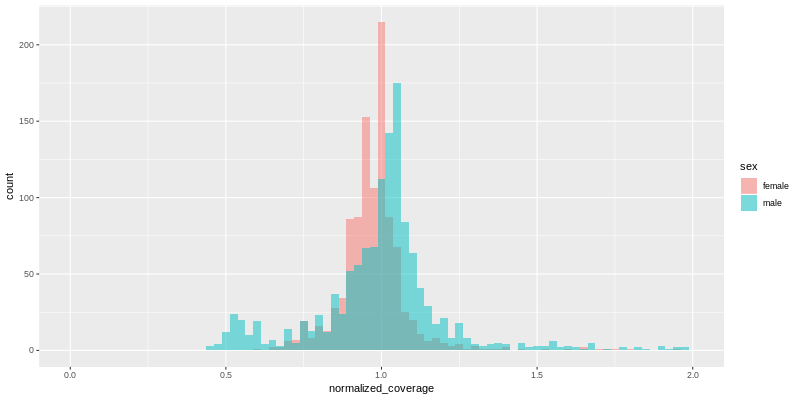

In [14]:
%%R -i depth_dir -w 800 -h 400
#%%R -i depth_dir -i normalized_table -i RD_table -w 800 -h 400 # could've used this to just import pandas DFs into R env rather than reading in from file

normalized_table %>% 
    filter(no_sites > 100000) %>% # filter out scaffolds smaller than 100 kb
    filter(rowSums(select(.,-scaffold,-no_sites)) <= 9*2) %>% # filter out scaffolds with twice the average coverage across samples -> repetitive elements, hidden paralogs, etc.
    gather(ID,normalized_coverage,-scaffold,-no_sites) %>% 
    mutate(sex=if_else(str_detect(ID,"_female"), "female", if_else(str_detect(ID,"_male"), "male", "NA"))) %>% 
        ggplot( aes(x=normalized_coverage,fill=sex)) + xlim(0,2) + #geom_density(n=1024) + xlim(0,2)
            geom_histogram(position='identity',binwidth=0.025, alpha=0.5)

## Check if there are any Y-linked scaffolds or scaffolds that appear to harbor repetitive elements (abnormally high coverage)

In [19]:
%%R

# pull out total size for normalization / weighing scaffold means
total_sites = sum(RD_table$no_sites)

# calculate sample means
sample_means <- RD_table %>% mutate_at(~.*(no_sites/total_sites), .vars=vars(-scaffold,-no_sites)) %>%
    select(-scaffold,-no_sites) %>% summarise_all(sum) %>% unlist() %>% as.vector()

# normalize and make new calls
norm_table <- RD_table %>% select(-scaffold,-no_sites) %>% as.matrix %>%
    sweep(2, sample_means, `/`) %>% as.data.frame() %>% 
    bind_cols(select(RD_table,scaffold,no_sites), .) %>%
    mutate(calls=case_when(
                        rowSums(select(.,contains("_male"))>=0.25)>=4 &
                            rowSums(select(.,contains("_female"))<0.25)>=3 ~ "Y_linked",
                        rowSums(select(.,-scaffold,-no_sites)>=1.5)>= 7 ~ "repeat",
                        TRUE ~ "NA"))

norm_table %>% filter(calls=="repeat") %>% print()
norm_table %>% filter(calls=="Y_linked") %>% print()

# A tibble: 21 x 12
   scaffold no_sites X18WPA_female03 bct16_male7 LIV15_female5 X18WPA_female02
   <fct>       <int>           <dbl>       <dbl>         <dbl>           <dbl>
 1 scaffol…   272981            1.75        1.82          1.17            1.80
 2 scaffol…   204127            2.30        1.72          1.14            1.95
 3 scaffol…   210543            7.31        6.53          8.67            7.60
 4 scaffol…   184582            1.72        1.52          1.46            1.60
 5 scaffol…   125526            1.79        2.75          1.80            1.61
 6 scaffol…    97858            2.35        3.45          1.66            1.77
 7 scaffol…    91626            5.29        5.01          1.39            3.48
 8 scaffol…    88133            2.51        1.77          1.93            2.77
 9 scaffol…    75711            3.14        2.90          1.29            3.55
10 scaffol…    57592            1.57        5.91          1.86            1.39
# … with 11 more rows, and 6 mor

-> Seems like there are a few repetitive regions and possibly a few Y-linked scaffolds, but the latter are all super small and can't be confidently called

## Make X-linked vs. autosome assignments

Assign scaffolds to autosomes vs. X-chromosome based on relative read depth in females and males. Don't consider scaffolds smaller than 100 kb (cannot be realiably assigned), or scaffolds that appear to harbor repetitive elements (i.e. those that exhibit unusally high coverage across the board). More specifially, <br>
- if read depth for a scaffold is more than 1.5 times the average read depth in at least 7 out of 9 samples -> repetitive region
- if relative read depth is larger than 0.25 in at least 4/5 males and smaller than 0.25 in at least 3/4 females -> Y-linked (expectation in males is 0.5 and in females 0)
- if relative read depth is smaller than a certain ratio in 4/5 males and higher in 3/4 females -> X-linked 

For the latter, try different ratios/thresholds, ranging from 0.5 to 0.95 in steps of 0.05 and do the assignments in several iterations, where overall and normalized read depth are re-calculated every round w/o previously assigned X-linked scaffolds.

In [495]:
%%R

min_size = 100000

for (thresh in seq(0.5,0.95,0.05)){

    assignment_table <- data.frame(matrix(nrow=1,ncol=9))
    colnames(assignment_table) <- c("iter","auto","repeat","too_small","X","auto_sites","rpt_sites","NA_sites","X_sites")
    i=1
    
    input_table <- RD_table
    
    for (i in seq(1,5)){
        
        # if it doesn't exist (1st iteration), add X_linked column
        input_table <- input_table %>% rowwise() %>%
                          mutate(calls = ifelse("calls" %in% names(.), calls, "NA")) %>% ungroup()
        
        # remove already called X-linked scaffolds prior to normalization and save as separate DF
        table_to_call <- input_table %>% filter(calls!="X_linked") %>% select(-calls)
        X_linked_scaffs <- input_table %>% filter(calls=="X_linked")
    
        # pull out total size for normalization / weighing scaffold means
        total_sites = sum(table_to_call$no_sites)
        
        # calculate sample means
        sample_means <- table_to_call %>% mutate_at(~.*(no_sites/total_sites), .vars=vars(-scaffold,-no_sites)) %>%
            select(-scaffold,-no_sites) %>% summarise_all(sum) %>% unlist() %>% as.vector()
        
        # normalize and make new calls
        new_calls_table <- table_to_call %>% select(-scaffold,-no_sites) %>% as.matrix %>%
            sweep(2, sample_means, `/`) %>% as.data.frame() %>% 
            bind_cols(select(table_to_call,scaffold,no_sites), .) %>%
            mutate(calls=
                        if_else(no_sites > min_size & rowSums(select(.,-scaffold,-no_sites)>=1.5)>= 7, "repeat",
                        if_else(no_sites > min_size & rowSums(select(.,contains("_male"))<thresh)>=4 &
                                    rowSums(select(.,contains("_female"))>thresh)>=3, "X_linked",
                        if_else(no_sites > min_size & rowSums(select(.,contains("_male"))>=0.25)>=4 &
                                    rowSums(select(.,contains("_female"))<0.25)>=3, "Y_linked",
                        if_else(no_sites <= min_size, "too_small", "autosome")))))
    
        # combine with X-linked DF (pulled out above)
        input_table <- rbind(X_linked_scaffs,new_calls_table) %>% arrange(scaffold)
        
        counts <- input_table %>% group_by(calls) %>% tally() %>% as.data.frame()
        sites <- input_table %>% group_by(calls) %>% summarize(no_sites=sum(no_sites)) %>% as.data.frame()
        
        assignment_table[i,1] <- i
        assignment_table[i,2] <- counts[1,2]
        assignment_table[i,3] <- counts[2,2]
        assignment_table[i,4] <- counts[3,2]
        assignment_table[i,5] <- counts[4,2]
        assignment_table[i,6] <- sites[1,2]
        assignment_table[i,7] <- sites[2,2]
        assignment_table[i,8] <- sites[3,2]
        assignment_table[i,9] <- sites[4,2]
        i=i+1
    }
    
    print(paste0("threshold is: ", thresh))
    assignment_table %>% mutate(prct_X=round(X_sites/auto_sites,4)*100) %>% print()
    
}

[1] "threshold is: 0.5"
  iter auto repeat too_small X auto_sites rpt_sites NA_sites X_sites prct_X
1    1  258      5       385 1  136905782    997759  7686158  150154   0.11
2    2  258      5       385 1  136905782    997759  7686158  150154   0.11
3    3  258      5       385 1  136905782    997759  7686158  150154   0.11
4    4  258      5       385 1  136905782    997759  7686158  150154   0.11
5    5  258      5       385 1  136905782    997759  7686158  150154   0.11
[1] "threshold is: 0.55"
  iter auto repeat too_small  X auto_sites rpt_sites NA_sites X_sites prct_X
1    1  247      5       385 12  127782582    997759  7686158 9273354   7.26
2    2  247      4       385 13  127269361    813177  7686158 9971157   7.83
3    3  247      4       385 13  127269361    813177  7686158 9971157   7.83
4    4  247      4       385 13  127269361    813177  7686158 9971157   7.83
5    5  247      4       385 13  127269361    813177  7686158 9971157   7.83
[1] "threshold is: 0.6"
  iter au